# Topic Modelling with BERTopic

The algorithm contains, roughly, 3 stages:

* Embed documents
* Extract document embeddings with BERT or any other embedding technique [sentence-transformers]
* Cluster Documents
* UMAP to reduce the dimensionality of embeddings
* HDBSCAN to cluster reduced embeddings and create clusters of semantically similar documents
* Create topic representation
* Extract and reduce topics with c-TF-IDF
* Improve coherence and diversity of words with Maximal Marginal Relevance

https://maartengr.github.io/BERTopic/index.html#overview

In [133]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [95]:
# function to convert to dataframe (credit https://gist.github.com/davidlenz/deff6cc7405d58efa32f4dfe12a6db8b)
def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))

    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']

    targets = pd.DataFrame( newsgroups_train.target_names)
    targets.columns=['title']

    out = pd.merge(df, targets, left_on='target', right_index=True)
    out['date'] = pd.to_datetime('now')
    out.to_csv('C:/Users/imoge/Projects/Datasets/20_newsgroup.csv')
    
twenty_newsgroup_to_csv()

# 20 Newsgroups Dataset

In [146]:
df = pd.read_csv('C:/Users/imoge/Projects/Datasets/20_newsgroup.csv')

In [147]:
df.shape

(11314, 5)

In [148]:
df.head()

,Unnamed: 0,text,target,title,date
0,0,I was wondering if anyone out there could enli...,7,rec.autos,2022-06-17 18:08:58.045803
1,17,I recently posted an article asking what kind ...,7,rec.autos,2022-06-17 18:08:58.045803
2,29,\nIt depends on your priorities. A lot of peo...,7,rec.autos,2022-06-17 18:08:58.045803
3,56,an excellent automatic can be found in the sub...,7,rec.autos,2022-06-17 18:08:58.045803
4,64,: Ford and his automobile. I need information...,7,rec.autos,2022-06-17 18:08:58.045803


In [149]:
targets = pd.DataFrame(df["title"].value_counts().reset_index())
targets.head()

,index,title
0,rec.sport.hockey,600
1,soc.religion.christian,599
2,rec.motorcycles,598
3,rec.sport.baseball,597
4,sci.crypt,595


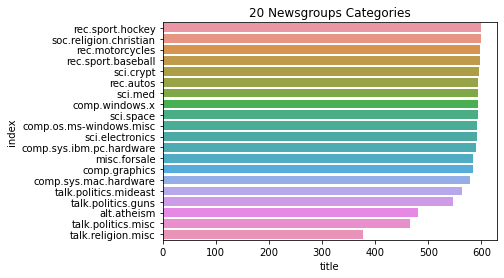

In [150]:
sns.barplot(data = targets,y = "index", x = "title")
plt.title("20 Newsgroups Categories");

In [151]:
df.isnull().sum()

Unnamed: 0      0
text          218
target          0
title           0
date            0
dtype: int64

In [155]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

In [153]:
rows_with_NaN.groupby("title",as_index = False)["date"].count().sort_values(by = "date",ascending = False)

,title,date
7,rec.autos,25
9,rec.sport.baseball,16
2,comp.os.ms-windows.misc,15
19,talk.religion.misc,14
12,sci.electronics,14
4,comp.sys.mac.hardware,13
14,sci.space,13
17,talk.politics.mideast,12
1,comp.graphics,12
11,sci.crypt,12


In [161]:
df2 = df.dropna()

In [162]:
df2.title.unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'],
      dtype=object)

In [163]:
df2['text'] = df2['text'].astype(str)

* Create word embeddings using sentence transformers (384 character)
* Compress into 2/3 dimensional space using UMAP (Uniform Manifold Approximation and Production)
* TSNE preserves similarity and PCA preserves dissimilarity and UMAP captures the best of both (based on k nearest neighbours) which captures local and global structures
* Clustering with HDBSCAN (hierarchy density based so allows easier visualisation and tuning but able to handle irregular shapes and outliers)
* Extract topics with c-TFIDF. This is a modified TFIDF to find the most relevant terms given all the documents in a cluster compared to TFIDF which finds the most relevant documents given the terms.


In [164]:
# Create embeddings, reduce dimensionality and cluster the embeddings
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words="english")

model = BERTopic(vectorizer_model=vectorizer,language='english', calculate_probabilities=True,verbose=True)
topics, probs = model.fit_transform(df2.text)

Batches: 100%|██████████| 354/354 [00:13<00:00, 25.29it/s] 
2022-06-17 19:23:13,934 - BERTopic - Transformed documents to Embeddings
2022-06-17 19:23:18,268 - BERTopic - Reduced dimensionality
2022-06-17 19:23:24,476 - BERTopic - Clustered reduced embeddings


In [165]:
model.get_topic_info().head(10)

,Topic,Count,Name
0,-1,3279,-1_use_like_dont_db
1,0,1078,0_team_game_season_games
2,1,509,1_patients_msg_medical_health
3,2,464,2_space_launch_nasa_lunar
4,3,423,3_car_bike_cars_engine
5,4,366,4_key_chip_clipper_encryption
6,5,284,5_card_monitor_video_vga
7,6,235,6_israel_israeli_arab_jews
8,7,219,7_nan_nan nan_tuna_spell tuna
9,8,182,8_fbi_koresh_batf_compound


In [183]:
# Total number of topics
model.get_topic_info().shape

(129, 3)

In [184]:
model.get_topic_info().tail(10)

,Topic,Count,Name
119,118,12,118_church_churches_cell_cell church
120,119,12,119_1st_cover_appears_art
121,120,12,120_book_james_bored considered_incredibly bored
122,121,12,121_copy protection_protection_copy_legitimate...
123,122,12,122_dos_dos6_qemm_stacker
124,123,11,123_holy spirit_holy_god_spirit
125,124,11,124_darren_reason_truth_beliefs
126,125,11,125_internet_privacy_anonymous_anonymity
127,126,11,126_plastic_paint_wax_scratches
128,127,10,127_drive_cable_hard_disk


In [166]:
model.get_topic(0)

[('team', 0.009607521297231126),
 ('game', 0.008741280105769852),
 ('season', 0.006977771388867626),
 ('games', 0.006891205662467065),
 ('play', 0.0065877451923255755),
 ('players', 0.006577658301789528),
 ('hockey', 0.006376877247199711),
 ('year', 0.005954972422405883),
 ('league', 0.005497952817233769),
 ('550', 0.005462844424720797)]

In [167]:
model.get_topic(1)

[('patients', 0.008492199084745553),
 ('msg', 0.007915979353743094),
 ('medical', 0.007294755058686028),
 ('health', 0.0069194357336425085),
 ('disease', 0.006729976174485594),
 ('food', 0.006700776645744664),
 ('doctor', 0.006286433088707747),
 ('pain', 0.006194769858067018),
 ('treatment', 0.005039275480354877),
 ('medicine', 0.004925787087741492)]

In [168]:
model.get_topic(2)

[('space', 0.018471542337219263),
 ('launch', 0.009646085297699242),
 ('nasa', 0.008306355562182873),
 ('lunar', 0.007369311422110505),
 ('orbit', 0.0070886028714789015),
 ('satellite', 0.0064832692714741295),
 ('shuttle', 0.006464044912562515),
 ('mission', 0.005605433054894078),
 ('moon', 0.005604089268917635),
 ('earth', 0.0053885697980900265)]

In [169]:
model.get_topic_freq().head(10)

,Topic,Count
0,-1,3279
1,0,1078
2,1,509
3,2,464
4,3,423
5,4,366
6,5,284
7,6,235
8,7,219
9,8,182


In [170]:
model.get_representative_docs(2)

['As for SF and advertising in space. There is a romantic episode\nin Mead\'s "The Big Ball of Wax" where the lovers are watching \nthe constellation Pepsi Cola rising over the horizon and noting\nthe some \'stars\' had slipped cause the Teamsters were on strike.\n\nThis was the inspiration for my article on orbiting a formation\nof space mirrors published in Spaceflight in 1986. As the reviews\nbut is it aesthetically desirable?  These days the only aesthetics\nthat count are the ones you can count!',
 ' \n \n  Of course; sorry for the misunderstanding.  I was referring to the fact\nthat far more aeronautical development took place in the \'30\'s.  For much\nof the \'20\'s, the super-abundance of Jennies and OX-5 engines held down the\nindustry.  By 1926, many of the obsolete WWI aircraft had been retired\nand Whirlwind had their power/weight ratio and reliability up to the point\nwhere long-distance flights became practical.  It\'s important to note that\nthe Atlantic was flown not o

In [171]:
model.visualize_topics()

In [173]:
model.visualize_hierarchy()

In [174]:
model.visualize_barchart()

In [175]:
model.visualize_heatmap()

In [176]:
model.visualize_term_rank()

In [181]:
model.visualize_distribution(probs[0])